Starting simulation at t=0. s for a duration of 4. s
4. s (100%) simulated in 4s


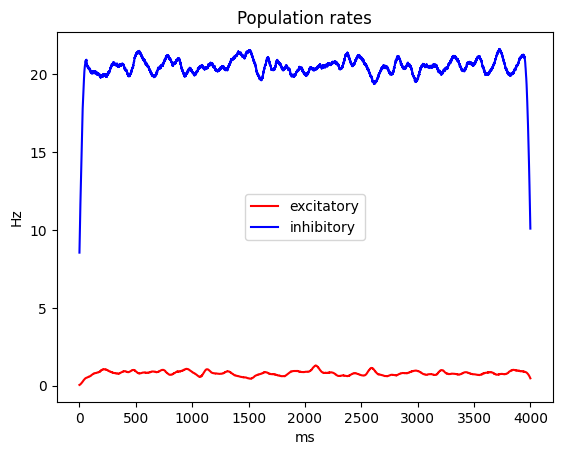

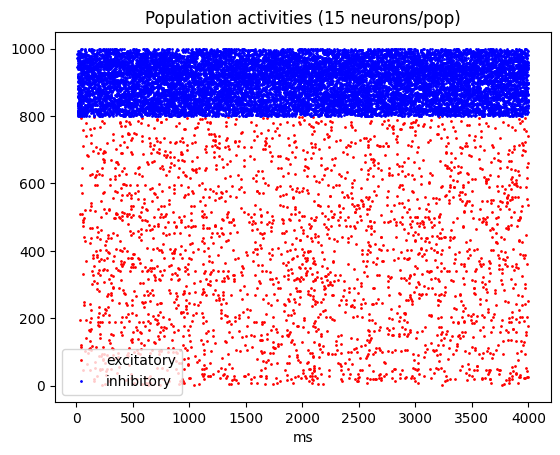

In [57]:
# based on Brunel and Wang 2001

from brian2 import *

start_scope()

# populations
N = 1000
N_E = int(N * 0.8)  # pyramidal neurons
N_I = int(N * 0.2)  # interneurons
N_E_stim = N_E * 0.05 # optogenetic probing in 5% of the population of pyramidal cells

# voltage
V_L = -70. * mV
V_thr_E = -50. * mV
V_thr_I = -52 * mV
V_reset = -55. * mV
V_E = 0. * mV
V_I = -70. * mV

# membrane capacitance
C_m_E = 0.5 * nF
C_m_I = 0.2 * nF

# membrane leak
g_m_E = 25. * nS
g_m_I = 20. * nS

# refractory period
tau_rp_E = 2. * ms
tau_rp_I = 1. * ms

# external stimuli
rate = 3 * Hz
C_ext = 800

# synapses
C_E = N_E
C_I = N_I

# AMPA (excitatory)
g_AMPA_ext_E = 2.08 * nS
g_AMPA_rec_E = 0.104 * nS * 800. / N_E
g_AMPA_ext_I = 1.62 * nS
g_AMPA_rec_I = 0.081 * nS * 800. / N_E
tau_AMPA = 2. * ms

# NMDA (excitatory)
g_NMDA_E = 0.327 * nS * 800. / N_E
g_NMDA_I = 0.258 * nS * 800. / N_E
tau_NMDA_rise = 2. * ms
tau_NMDA_decay = 100. * ms
alpha = 0.5 / ms
Mg2 = 1.

# GABAergic (inhibitory)
g_GABA_E = 1.25 * nS * 200. / N_I
g_GABA_I = 0.973 * nS * 200. / N_I
tau_GABA = 10. * ms

# modeling
eqs_E = '''
dv / dt = (- g_m_E * (v - V_L) - I_syn) / C_m_E : volt (unless refractory)

I_syn = I_AMPA_ext + I_AMPA_rec + I_NMDA_rec + I_GABA_rec : amp

I_AMPA_ext = g_AMPA_ext_E * (v - V_E) * s_AMPA_ext : amp
I_AMPA_rec = g_AMPA_rec_E * (v - V_E) * 1 * s_AMPA : amp
ds_AMPA_ext / dt = - s_AMPA_ext / tau_AMPA : 1
ds_AMPA / dt = - s_AMPA / tau_AMPA : 1

I_NMDA_rec = g_NMDA_E * (v - V_E) / (1 + Mg2 * exp(-0.062 * v / mV) / 3.57) * s_NMDA_tot : amp
s_NMDA_tot : 1

I_GABA_rec = g_GABA_E * (v - V_I) * s_GABA : amp
ds_GABA / dt = - s_GABA / tau_GABA : 1
'''

eqs_I = '''
dv / dt = (- g_m_I * (v - V_L) - I_syn) / C_m_I : volt (unless refractory)

I_syn = I_AMPA_ext + I_AMPA_rec + I_NMDA_rec + I_GABA_rec : amp

I_AMPA_ext = g_AMPA_ext_I * (v - V_E) * s_AMPA_ext : amp
I_AMPA_rec = g_AMPA_rec_I * (v - V_E) * 1 * s_AMPA : amp
ds_AMPA_ext / dt = - s_AMPA_ext / tau_AMPA : 1
ds_AMPA / dt = - s_AMPA / tau_AMPA : 1

I_NMDA_rec = g_NMDA_I * (v - V_E) / (1 + Mg2 * exp(-0.062 * v / mV) / 3.57) * s_NMDA_tot : amp
s_NMDA_tot : 1

I_GABA_rec = g_GABA_I * (v - V_I) * s_GABA : amp
ds_GABA / dt = - s_GABA / tau_GABA : 1
'''

P_E = NeuronGroup(N_E, eqs_E, threshold='v > V_thr_E', reset='v = V_reset', refractory=tau_rp_E, method='euler')
P_E.v = V_L
P_I = NeuronGroup(N_I, eqs_I, threshold='v > V_thr_I', reset='v = V_reset', refractory=tau_rp_I, method='euler')
P_I.v = V_L

eqs_glut = '''
s_NMDA_tot_post = w * s_NMDA : 1 (summed)
ds_NMDA / dt = - s_NMDA / tau_NMDA_decay + alpha * x * (1 - s_NMDA) : 1 (clock-driven)
dx / dt = - x / tau_NMDA_rise : 1 (clock-driven)
w : 1
'''

eqs_pre_glut = '''
s_AMPA += w
x += 1
'''

eqs_pre_gaba = '''
s_GABA += 1
'''

eqs_pre_ext = '''
s_AMPA_ext += 1
'''

# E to E
#C_E_E = Synapses(P_E, P_E, model=eqs_glut, on_pre=eqs_pre_glut, method='euler')
#C_E_E.connect('i != j',)
#C_E_E.w[:] = 1

# E to I
C_E_I = Synapses(P_E, P_I, model=eqs_glut, on_pre=eqs_pre_glut, method='euler')
C_E_I.connect('i != j', p=0.2)
# C_E_I.w[:] = 1

# I to I
C_I_I = Synapses(P_I, P_I, on_pre=eqs_pre_gaba, method='euler')
C_I_I.connect('i != j', p=0.2)

# I to E
C_I_E = Synapses(P_I, P_E, on_pre=eqs_pre_gaba, method='euler')
C_I_E.connect('i != j', p=0.2)

# external noise
C_P_E = PoissonInput(P_E, 's_AMPA_ext', C_ext, rate, '1')
C_P_I = PoissonInput(P_I, 's_AMPA_ext', C_ext, rate, '1')

# monitors
sp_E = SpikeMonitor(P_E)
sp_I = SpikeMonitor(P_I)
mon=StateMonitor(P_E, 'v', record=True)

# r_E_sels = [PopulationRateMonitor(P_E[pi:pi + N_sub]) for pi in range(N_non, N_non + p * N_sub, N_sub)]
r_E = PopulationRateMonitor(P_E)
r_I = PopulationRateMonitor(P_I)

# simulate
net = Network(collect())
net.run(4 * second, report='stdout')

# plotting
title('Population rates')
xlabel('ms')
ylabel('Hz')

plot(r_E.t / ms, r_E.smooth_rate(width=25 * ms) / Hz,'r', label='excitatory')
plot(r_I.t / ms, r_I.smooth_rate(width=25 * ms) / Hz,'b', label='inhibitory')

legend()
figure()

title(f"Population activities ({N_activity_plot} neurons/pop)")
xlabel('ms')

plot(sp_E.t / ms, sp_E.i, 'r.', markersize=2,
     label="excitatory")
plot(sp_I.t / ms, sp_I.i + N * 0.8, 'b.', markersize=2,
     label="inhibitory")

legend()
show()

(-70.0, -50.0)

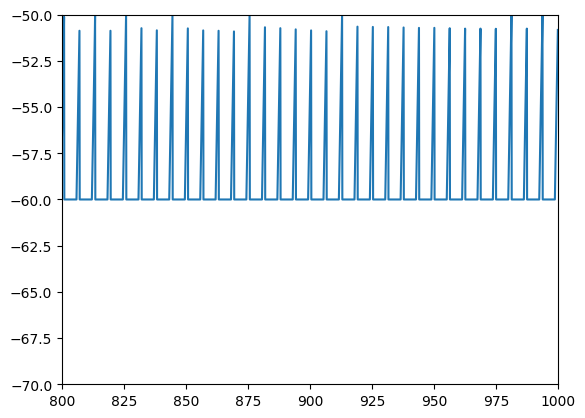

(800.0, 1000.0)

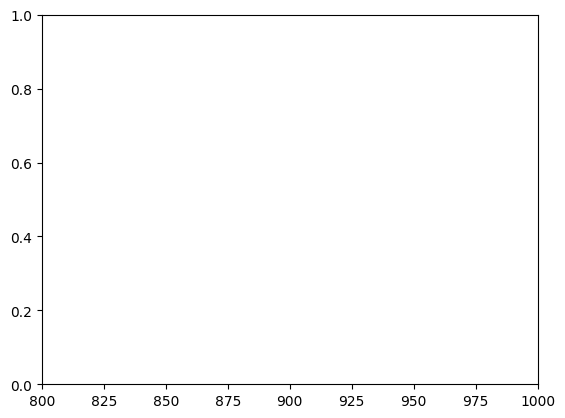

In [5]:
xlim(0.8*1e3, 1*1e3)
